In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
from pypfopt.efficient_frontier import EfficientFrontier
import pypfopt.base_optimizer
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov

In [2]:
pd.options.mode.chained_assignment = None
if 'mag7.csv' not in os.listdir():
    mag7_tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
    mag7 = yf.download(mag7_tickers, start='2013-01-01', end='2023-12-31')[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    mag7.index = pd.to_datetime(mag7.index)
    mag7 = mag7.swaplevel(0, 1, axis=1).sort_index(axis=1)
    mag7.to_csv('mag7.csv')
else:
    mag7 = pd.read_csv('mag7.csv', header=[0, 1], index_col=0, parse_dates=True)

# Trading Strategy
First use Double Bollinger Band indicator to determine the trend of the stock <br>
Next, use MACD to determine the entry and exit points based off on the trend

In [7]:
ticker = 'AAPL'
data = mag7[ticker].copy()

data['rolling_mean'] = data['Close'].rolling(window=20).mean()
data['rolling_std'] = data['Close'].rolling(window=20).std()
data['A1'] = data['rolling_mean'] + (data['rolling_std'] * 2)
# data['A1'] = data['A1'].shift(1)
data['A2'] = data['rolling_mean'] - (data['rolling_std'] * 2)
# data['A2'] = data['A2'].shift(1)
data['B1'] = data['rolling_mean'] + (data['rolling_std'] * 1)
# data['B1'] = data['B1'].shift(1)
data['B2'] = data['rolling_mean'] - (data['rolling_std'] * 1)
# data['B2'] = data['B2'].shift(1)

data['26MA'] = data['Close'].ewm(span=26, adjust=False).mean()
# data['26MA'] = data['26MA'].shift(1)
data['12MA'] = data['Close'].ewm(span=12, adjust=False).mean()
# data['12MA'] = data['12MA'].shift(1)
data['MACD'] = data['12MA'] - data['26MA']
# data['MACD'] = data['MACD'].shift(1)
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

data.tail()

,Adj Close,Close,High,Low,Open,Volume,rolling_mean,rolling_std,A1,A2,B1,B2,26MA,12MA,MACD,Signal
Date,,,,,,,,,,,,,,,,
2023-12-22,193.091385,193.600006,195.410004,192.970001,195.179993,37122800,193.668501,2.911017,199.490535,187.846466,196.579518,190.757483,192.102573,194.738889,2.636317,3.236689
2023-12-26,192.542816,193.050003,193.889999,192.830002,193.610001,28919300,193.831501,2.770282,199.372064,188.290938,196.601783,191.061219,192.172753,194.479061,2.306308,3.050613
2023-12-27,192.642548,193.149994,193.500000,191.089996,192.490005,48087700,193.969001,2.656926,199.282852,188.655150,196.625927,191.312075,192.245141,194.274589,2.029448,2.846380
2023-12-28,193.071426,193.580002,194.660004,193.169998,194.139999,34049900,194.179501,2.430509,199.040519,189.318484,196.610010,191.748993,192.344020,194.167729,1.823710,2.641846
2023-12-29,192.024185,192.529999,194.399994,191.729996,193.899994,42628800,194.308501,2.256446,198.821393,189.795610,196.564947,192.052056,192.357796,193.915771,1.557975,2.425072


In [15]:
position_df = pd.DataFrame(index=data.index)
position_df['position'] = np.where(((data['MACD'] > data['Signal']) & (data['High'] > data['B1'])), 1, 0)
position_df['position'] = np.where(((data['MACD'] < data['Signal']) & (data['Low'] < data['B2'])), -1, position_df['position'])
position_df['position'] = position_df['position'].shift(1)
position_df

,position
Date,
2013-01-02,NaN
2013-01-03,0.0
2013-01-04,0.0
2013-01-07,0.0
2013-01-08,0.0
...,...
2023-12-22,0.0
2023-12-26,0.0
2023-12-27,0.0


<Axes: xlabel='Date'>

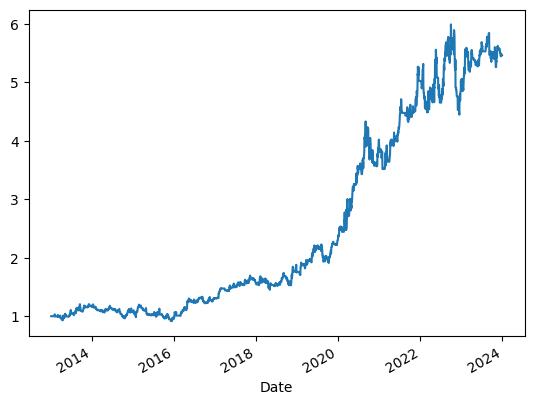

In [28]:
results_df = pd.DataFrame(index=data.index)
results = position_df['position'] * data['Close'].pct_change()
results_df['strategy'] = results
results_df['cumulative'] = (1 + results_df['strategy']).cumprod()
results_df['cumulative'].plot()